# Sistema de recomendación
### 1. Introducción

Este trabajo tiene como objetivo utilizar Spark ML y el algoritmo de recomendación ALS para generar un listado de recomendaciones de series y películas de anime para el usuario "EP" (con ID 666666). Se cuenta con archivos que contienen información sobre valoraciones de usuarios, así como detalles de cada serie y película. Además, se utilizará la API Jikan para obtener información detallada de cada anime recomendado. El objetivo final es mostrar las recomendaciones ordenadas por valoración media y proporcionar información adicional como sinopsis, imagen y trailer.


### 2. Librerías
Instalación e importación de las librerias necesarias para la práctica

In [31]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS 
from pyspark.sql import Row
import pyspark.sql.functions as F
import pandas as pd
import requests 
from PIL import Image
from io import BytesIO
from IPython.display import YouTubeVideo
from pyspark.sql.functions import when
import time

### 3. Sistema de recomendación

### Lectura de datos
Cargamos los datos de valoraciones y de información de series y películas. Además, se crea un dataframe con las valoraciones del usuario "EP" (con ID 666666). Hay que remarcar que los datos estan delimitados por ','.

In [2]:
anime = spark.read.options(delimiter=',',header='True', inferSchema=True).csv("./anime.csv")
anime.show(5)

+---+--------------------+-----+--------------------+--------------------+---------------------------+-----+--------+--------------------+-----------+--------------------+--------------------+--------------+--------+---------------+--------------------+------+----------+---------+---------+--------+---------+-------+-------+-------------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+
| ID|                Name|Score|              Genres|        English name|              Japanese name| Type|Episodes|               Aired|  Premiered|           Producers|           Licensors|       Studios|  Source|       Duration|              Rating|Ranked|Popularity|  Members|Favorites|Watching|Completed|On-Hold|Dropped|Plan to Watch|Score-10| Score-9| Score-8|Score-7|Score-6|Score-5|Score-4|Score-3|Score-2|Score-1|
+---+--------------------+-----+--------------------+--------------------+---------------------------+-----+--------+--------------------+-----------+--

In [3]:
ratings = spark.read.options(delimiter=',',header='True', inferSchema=True).csv("./rating_complete.csv")
ratings.show(5)

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      0|     430|     9|
|      0|    1004|     5|
|      0|    3010|     7|
|      0|     570|     7|
|      0|    2762|     9|
+-------+--------+------+
only showing top 5 rows



In [4]:
ratings_user = spark.read.options(delimiter=',',header='False', inferSchema=True).csv("./valoraciones_EP.csv")
ratings_user.show(5)

+------+-----+---+
|   _c0|  _c1|_c2|
+------+-----+---+
|666666|    5|  6|
|666666|   30|  5|
|666666|  133|  8|
|666666|27879|  8|
|666666|27909|  9|
+------+-----+---+
only showing top 5 rows



### Preprocesamiento de datos
Se renombran las columnas para que coincidan con los nombres de las columnas del dataframe de las valoraciones del usuario "EP" y no haya problemas de colissiones, 

In [5]:
# Renombramos las columnas de ratings_user
ratings_user = ratings_user.withColumnRenamed("_c0", "user_id")
ratings_user = ratings_user.withColumnRenamed("_c1", "anime_id")
ratings_user = ratings_user.withColumnRenamed("_c2", "rating")
# Renombramos la columna ID de anime
anime = anime.withColumnRenamed("ID", "anime_id")


Unimos los dataframes de valoraciones y de información de series y películas para obtener un dataframe con toda la información necesaria para el sistema de recomendación. Además, se eliminan los que no tienen información de valoración.

In [6]:
# Unimos los ratings de los usuarios con los ratings de los animes
ratings_final = ratings.union(ratings_user)
# Unimos los ratings con los datos de los animes. 
# Unir score nos permite eliminar los animes que no tienen puntuación para que no nos afecten en el sistema de recomendación.
# Por eso la unimos pese a dropearla después
ratings_final = ratings_final.join(anime[["anime_id", "Score", "Type", "Episodes"]], on = "anime_id", how="inner")
# Eliminamos los animes que no tienen puntuación
ratings_final = ratings_final.filter(ratings_final.Score != "Unknown")


En el anime aparte de las series y las peliculas se encuentran las ONAs y las OVAs estas las eliminamos porque hay veces son unas o son otras y no hay forma de saberlo porque existen casos que pese a tener varios capitulos se deberian considerarse peliculas y no series.

In [7]:
movies = ratings_final.filter(ratings_final.Type == "Movie") # filtramos las películas
series = ratings_final.filter(ratings_final.Type == "TV") # filtramos las series
# Eliminamos las columnas que no nos interesan
movies = movies.drop("Type", "Episodes", "Score")
series = series.drop("Type", "Episodes", "Score")

Modelo de recomendación de películas

In [8]:
# Dividimos los datos en train y test
(training, test) = movies.randomSplit([0.75, 0.25]) 
# Creamos el modelo con los parámetros que queremos
als = ALS(maxIter=15, regParam=0.1, userCol="user_id", itemCol="anime_id", ratingCol="rating", coldStartStrategy="drop")
model1 = als.fit(training)


Evaluar el modelo de recomendación de películas

In [9]:
predictions = model1.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions) 
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.189202560299203


Recomendaciones de películas para el usuario "EP" (con ID 666666)

In [19]:
# Seleccionamos el usuario 666666
movies_user = movies.select(als.getUserCol()).distinct().where(F.col(als.getUserCol()).isin([666666]))
# Hacemos las recomendaciones para el usuario 666666
movies_user_rec = model1.recommendForUserSubset(movies_user,5)
movies_user_rec.show(5, False)

+-------+----------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                               |
+-------+----------------------------------------------------------------------------------------------+
|666666 |[{39486, 6.6268325}, {31758, 6.0631404}, {164, 5.9840474}, {28957, 5.955726}, {15335, 5.8943}]|
+-------+----------------------------------------------------------------------------------------------+



In [20]:
# Seleccionamos el usuario 666666
movies_user_rec = movies_user_rec.select("*", F.explode("recommendations").alias("aux"))
# Seleccionamos las columnas que nos interesan
movies_user_rec = movies_user_rec.withColumn("anime_id", F.col("aux").getItem("anime_id"))
# Seleccionamos las columnas que nos interesan y auxiliar
movies_user_rec = movies_user_rec.drop("recommendations", "aux")
# Unimos las recomendaciones con los datos de los animes
movies_user_rec = movies_user_rec.join(anime[["anime_id", "Name", "English name"]], on = "anime_id", how="inner")
movies_user_rec.show(5, False)

+--------+-------+-----------------------------------------------------+-----------------+
|anime_id|user_id|Name                                                 |English name     |
+--------+-------+-----------------------------------------------------+-----------------+
|39486   |666666 |Gintama: The Final                                   |Unknown          |
|31758   |666666 |Kizumonogatari III: Reiketsu-hen                     |Unknown          |
|164     |666666 |Mononoke Hime                                        |Princess Mononoke|
|28957   |666666 |Mushishi Zoku Shou: Suzu no Shizuku                  |Unknown          |
|15335   |666666 |Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare|Unknown          |
+--------+-------+-----------------------------------------------------+-----------------+



API Jikan para películas

In [43]:
# Creamos columnas nuevas para almacenar las url, sinopsis y trailer
movies_rec = movies_user_rec.withColumn("url", F.lit(""))
movies_rec = movies_rec.withColumn("synopsis", F.lit(""))
movies_rec = movies_rec.withColumn("trailer", F.lit(""))
movies_rec = movies_rec.withColumn("duration", F.lit(""))
url_base = "https://api.jikan.moe/v4/anime/" # definimos la url
session = requests.Session() # creamos una sesión

Recomendación de 5 películas para el usuario 666666
Título:  Gintama: The Final


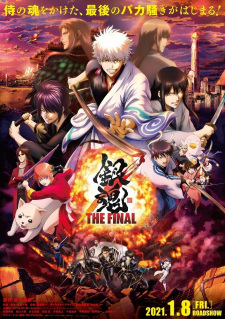

Duración:  1 hr 44 min
Sinopsis:  Two years have passed following the Tendoshuu's invasion of the O-Edo Central Terminal. Since then, the Yorozuya have gone their separate ways. Foreseeing Utsuro's return, Gintoki Sakata begins surveying Earth's ley lines for traces of the other man's Altana. After an encounter with the remnants of the Tendoshuu—who continue to press on in search of immortality—Gintoki returns to Edo.

Later, the regrouped Shinsengumi and Yorozuya begin an attack on the occupied Central Terminal. With the Altana harvested by the wreckage of the Tendoshuu's ship in danger of detonating, the Yorozuya and their allies fight their enemies while the safety of Edo—and the rest of the world—hangs in the balance. Fulfilling the wishes of their teacher, Shouyou Yoshida's former students unite and relive their pasts one final time in an attempt to save their futures.

[Written by MAL Rewrite]
Trailer:  https://www.youtube.com/watch?v=Zn1filVUyf8


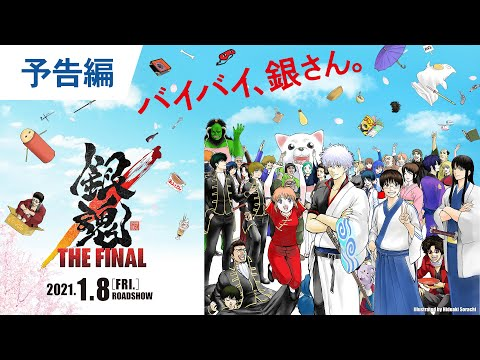

_______________________________________________________________________________________________________________________________________________________________________________________

Título:  Kizumonogatari III: Reiketsu-hen


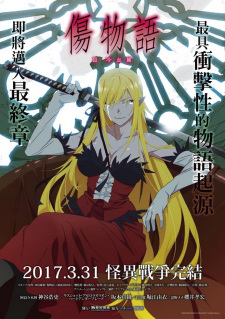

Duración:  1 hr 23 min
Sinopsis:  After helping revive the legendary vampire Kiss-shot Acerola-orion Heart-under-blade, Koyomi Araragi has become a vampire himself and her servant. Kiss-shot is certain she can turn him back into a human, but only once regaining her full power. 

Araragi has hunted down the three vampire hunters that defeated Kiss-shot and retrieved her limbs to return her to full strength. However, now that Araragi has almost accomplished what he’s been fighting for this whole time, he has to consider if this is what he really wants. Once he revives this powerful immortal vampire, there is no telling what she might do, and there would be no way of stopping her.

But there is more to the story that Araragi doesn’t understand. If a newborn vampire like him could defeat the hunters, how did they overpower Kiss-shot? Can he trust her to turn him back to a human? And how is that even possible in the first place?

Araragi is at his limit but he must come to a decision, and i

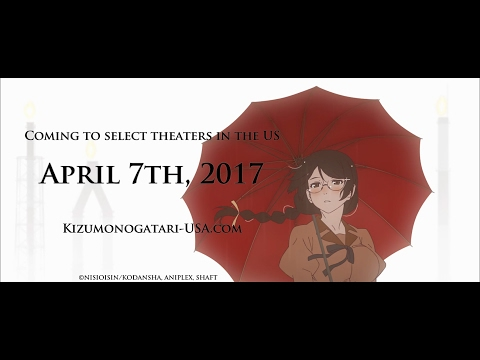

_______________________________________________________________________________________________________________________________________________________________________________________

Título:  Mononoke Hime


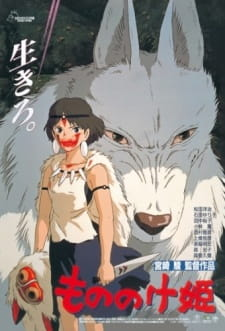

Duración:  2 hr 13 min
Sinopsis:  When an Emishi village is attacked by a fierce demon boar, the young prince Ashitaka puts his life at stake to defend his tribe. With its dying breath, the beast curses the prince's arm, granting him demonic powers while gradually siphoning his life away. Instructed by the village elders to travel westward for a cure, Ashitaka arrives at Tatara, the Iron Town, where he finds himself embroiled in a fierce conflict: Lady Eboshi of Tatara, promoting constant deforestation, stands against Princess San and the sacred spirits of the forest, who are furious at the destruction brought by the humans. As the opposing forces of nature and mankind begin to clash in a desperate struggle for survival, Ashitaka attempts to seek harmony between the two, all the while battling the latent demon inside of him. Princess Mononoke is a tale depicting the connection of technology and nature, while showing the path to harmony that could be achieved by mutual acceptance.

[Wri

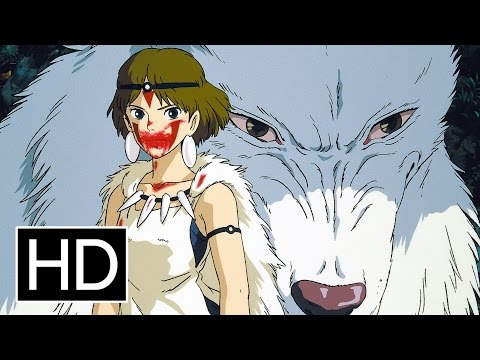

_______________________________________________________________________________________________________________________________________________________________________________________

Título:  Mushishi Zoku Shou: Suzu no Shizuku


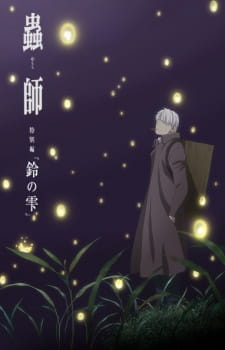

Duración:  47 min
Sinopsis:  On a warm summer day, a boy heard the sound of bells ringing, as if in celebration, in the mountain near his home. Several years later in that same mountain, the mushishi Ginko encounters a strange girl with weeds growing out of her body. Soon after, Ginko coincidentally runs into the now grown-up boy Yoshiro on his way off the mountain. With Yoshiro's help, Ginko soon begins to uncover who this mysterious girl is and what happened to her.

An adaptation of the last arc in the manga, Mushishi Zoku Shou: Suzu no Shizuku follows Ginko's peculiar journey amidst the occult to unravel the mystery behind the enigmatic girl called Kaya and the mountain that has become her home.

[Written by MAL Rewrite]
Trailer:  https://www.youtube.com/watch?v=BDdPKndfd68


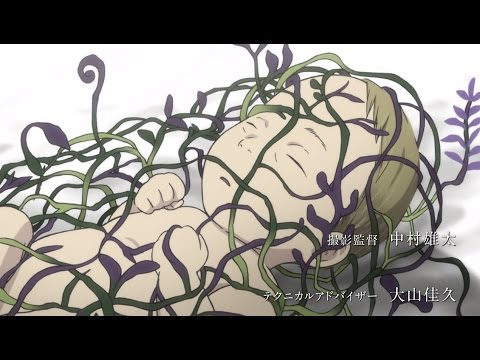

_______________________________________________________________________________________________________________________________________________________________________________________

Título:  Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare


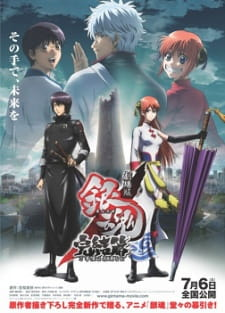

Duración:  1 hr 50 min
Sinopsis:  When Gintoki apprehends a movie pirate at a premiere, he checks the camera's footage and finds himself transported to a bleak, post-apocalyptic version of Edo, where a mysterious epidemic called the "White Plague" has ravished the world's population. It turns out that the movie pirate wasn't a pirate after all—it was an android time machine, and Gintoki has been hurtled five years into the future! Shinpachi and Kagura, his Yorozuya cohorts, have had a falling out and are now battle-hardened solo vigilantes and he himself has been missing for years, disappearing without a trace after scribbling a strange message in his journal.

Setting out in the disguise given to him by the android time machine, Gintoki haphazardly reunites the Yorozuya team to investigate the White Plague, and soon discovers that the key to saving the future lies in the darkness of his own past. Determined to confront a powerful foe, he makes an important discovery—with a ragtag band

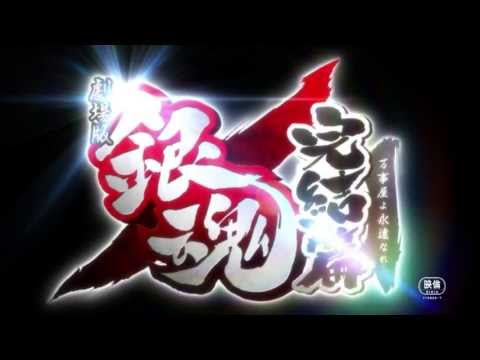

_______________________________________________________________________________________________________________________________________________________________________________________

+--------+-------+-----------------------------------------------------+-----------------+-----------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [47]:
print('Recomendación de 5 películas para el usuario 666666')
for i, value in enumerate (list(movies_rec.select(movies_rec.anime_id).toPandas()['anime_id'])):
    req_url = requests.get(url_base + str(value) + "/full")# hacemos la solicitud a la url completa
    dict_anime = req_url.json() # convertimos la respuesta en un diccionario
    movies_rec = movies_rec.withColumn("url",  when(movies_rec["anime_id"] == value, dict_anime["data"]["url"]).otherwise(movies_rec["url"]))
    movies_rec = movies_rec.withColumn("synopsis",  when(movies_rec["anime_id"] == value, dict_anime["data"]["synopsis"]).otherwise(movies_rec["synopsis"]))
    movies_rec = movies_rec.withColumn("trailer",  when(movies_rec["anime_id"] == value, dict_anime["data"]["trailer"]["url"]).otherwise(movies_rec["trailer"]))
    movies_rec = movies_rec.withColumn("duration",  when(movies_rec["anime_id"] == value, dict_anime["data"]["duration"]).otherwise(movies_rec["duration"]))
    # Mostramos los datos de las películas recomendadas
    print('Título: ',dict_anime["data"]["title"])
    image_url = dict_anime["data"]["images"]["jpg"]["image_url"]
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    display(image)
    print('Duración: ',dict_anime["data"]["duration"])
    print('Sinopsis: ',dict_anime["data"]["synopsis"])
    print('Trailer: ',dict_anime["data"]["trailer"]["url"])
    youtube_id = dict_anime["data"]["trailer"]["youtube_id"]
    video = YouTubeVideo(id=youtube_id, width=400, height=300)
    display(video)
    print('_______________________________________________________________________________________________________________________________________________________________________________________')
    print('')
    time.sleep(2)
# Mostramos las recomendaciones con todos los datos
movies_rec.show(5, False)

In [48]:
movies_rec.toPandas().to_csv('./movies_user666666.txt', header=True, index=None, sep=',')

Modelo de recomendación de series

In [13]:
# Dividimos los datos en train y test
(training, test) = series.randomSplit([0.75, 0.25]) 
# Creamos el modelo con los parámetros que queremos
als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="anime_id", ratingCol="rating", coldStartStrategy="drop", checkpointInterval=2)
# model2 = als.fit(training) esta es la linea que me da error la comento para que si la ejecuto por error no tenga que reiniciar programa

Py4JJavaError: An error occurred while calling o236.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 144.0 failed 1 times, most recent failure: Lost task 1.0 in stage 144.0 (TID 359) (DESKTOP-G0K4DMI executor driver): java.lang.OutOfMemoryError: Java heap space

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1266)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:988)
	at org.apache.spark.ml.recommendation.ALS.$anonfun$fit$1(ALS.scala:737)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:714)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.lang.OutOfMemoryError: Java heap space


Evaluar el modelo de recomendación de series

In [ ]:
predictions = model2.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions) 
print("Root-mean-square error = " + str(rmse))

Recomendaciones de series para el usuario "EP" (con ID 666666)

In [ ]:
# Seleccionamos el usuario 666666
serie_user = series.select(als.getUserCol()).distinct().where(F.col(als.getUserCol()).isin([666666]))
# Hacemos las recomendaciones para el usuario 666666
series_user_rec = model2.recommendForUserSubset(movies_user,5)
series_user_rec.show(5)

In [ ]:
# Seleccionamos el usuario 666666
series_user_rec = series_user_rec.select("*", F.explode("recommendations").alias("aux"))
# Seleccionamos las columnas que nos interesan
series_user_rec = series_user_rec.withColumn("anime_id", F.col("aux").getItem("anime_id"))
# Seleccionamos las columnas que nos interesan y auxiliar
series_user_rec = series_user_rec.drop("recommendations", "aux")
# Unimos las recomendaciones con los datos de los animes
series_user_rec = series_user_rec.join(anime[["anime_id", "Name", "English name"]], on = "anime_id", how="inner")
series_user_rec.show(5, False)

API Jikan para series

In [ ]:
# Creamos columnas nuevas para almacenar las url, sinopsis y trailer
series_rec = series_user_rec.withColumn("url", F.lit(""))
series_rec = series_rec.withColumn("synopsis", F.lit(""))
series_rec = series_rec.withColumn("trailer", F.lit(""))
series_rec = series_rec.withColumn("duration", F.lit(""))
url_base = "https://api.jikan.moe/v4/anime/" # definimos la url
session = requests.Session() # creamos una sesión

In [ ]:
print('Recomendación de 5 series para el usuario 666666')
for i, value in enumerate (list(series_rec.select(series_rec.anime_id).toPandas()['anime_id'])):
    req_url = requests.get(url_base + str(value) + "/full")
    dict_anime = req_url.json() 
    series_rec = series_rec.withColumn("url",  when(series_rec["anime_id"] == value, dict_anime["data"]["url"]).otherwise(series_rec["url"]))
    series_rec = series_rec.withColumn("synopsis",  when(series_rec["anime_id"] == value, dict_anime["data"]["synopsis"]).otherwise(series_rec["synopsis"]))
    series_rec = series_rec.withColumn("trailer",  when(series_rec["anime_id"] == value, dict_anime["data"]["trailer"]["url"]).otherwise(series_rec["trailer"]))
    series_rec = series_rec.withColumn("duration",  when(series_rec["anime_id"] == value, dict_anime["data"]["duration"]).otherwise(series_rec["duration"]))
    # Mostramos los datos de las películas recomendadas
    print('Título: ',dict_anime["data"]["title"])
    image_url = dict_anime["data"]["images"]["jpg"]["image_url"]
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    display(image)
    print('Duración: ',dict_anime["data"]["duration"])
    print('Sinopsis: ',dict_anime["data"]["synopsis"])
    print('Trailer: ',dict_anime["data"]["trailer"]["url"])
    youtube_id = dict_anime["data"]["trailer"]["youtube_id"]
    video = YouTubeVideo(id=youtube_id, width=400, height=300)
    display(video)
    print('_______________________________________________________________________________________________________________________________________________________________________________________')
    print('')
    time.sleep(2)
series_rec.show(5, False)

In [ ]:
series_rec.toPandas().to_csv('./movies_user666666.txt', header=True, index=None, sep=',')